<a href="https://colab.research.google.com/github/qingqingye/GT-impact-of-network-with_lda-6607-project-topic2/blob/main/dataclean_lda_6607project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

In [ ]:
from operator import truediv
from sqlite3 import DataError
import pandas as pd


df = pd.read_csv(r'Expt3-ece6607-2022-fall modified.csv')
dataframe = df[df['Your suggestions'].str.contains('\n\n')]
dataframe = dataframe.reset_index(drop = True)

dataframe['Before'] = dataframe['Your suggestions'].str.split('\n\n', expand = True)[0]
dataframe['After'] = dataframe['Your suggestions'].str.split('\n\n', expand = True)[1]
dataframe["Before"]= dataframe["Before"].str.split("\n", expand = False)
dataframe["After"]= dataframe["After"].str.split("\n", expand = False)

dataframe.to_csv('clean.csv', index=False)

In [ ]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [ ]:
from sklearn.utils import as_float_array
# test_df = pd.read_csv('test.csv')
# print(test_df)

# reindexed_data = test_df['Before']
# reindexed_data.index = test_df['Timestamp']


dict = {'Timestamp': [],
        'Type': [],
        'Priority': [],
        'Suggestion': [],
        'index_num': []}
for i in range(dataframe.shape[0]):
  before_list = dataframe.loc[i, 'Before']
  after_list = dataframe.loc[i, 'After']
  min_len = min(len(before_list), len(after_list))
  for j, suggestion in enumerate(before_list[: min_len]):
    priority = j + 1
    if len(suggestion) == 0:
      continue
    dict['Timestamp'].append(dataframe.Timestamp[i])
    dict['Type'].append(0)
    dict['Priority'].append(priority)
    dict['Suggestion'].append(suggestion)
  for j, suggestion in enumerate(after_list[: min_len]):
    priority = j + 1
    if len(suggestion) == 0:
      continue
    dict['Timestamp'].append(dataframe.Timestamp[i])
    dict['Type'].append(1)
    dict['Priority'].append(priority)
    dict['Suggestion'].append(suggestion)
dict['index_num'] = range(len(dict['Type']))

indexed_data = pd.DataFrame(dict)
indexed_data.dropna()
indexed_data.to_csv('indexed_data.csv', index=False)
print(indexed_data.shape[0])

# count_vectorizer = CountVectorizer(stop_words='english')
# words, word_values = get_top_n_words(n_top_words=10,
#                                      count_vectorizer=count_vectorizer, 
#                                      text_data=reindexed_data)

# fig, ax = plt.subplots(figsize=(16,8))
# ax.bar(range(len(words)), word_values);
# ax.set_xticks(range(len(words)));
# ax.set_xticklabels(words, rotation='vertical');
# ax.set_title('Top words in headlines dataset (excluding stop words)');
# ax.set_xlabel('Word');
# ax.set_ylabel('Number of occurences');
# plt.show()

517


In [ ]:
df_indexed = pd.read_csv('indexed_data.csv')
reindexed_data = df_indexed['Suggestion']
reindexed_data.index = df_indexed['index_num']
# reindexed_data.index = 

In [ ]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=500, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[0]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[0]))

Headline before vectorization: More ECE course options.
Headline after vectorization: 
  (0, 178)	1
  (0, 123)	1
  (0, 399)	1


In [ ]:
n_topics = 20

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
# Define helper functions
def get_top_n_words_(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)  
    print(top_n_word_indices) 
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
#@title Default title text
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)
top_n_words_lda = get_top_n_words_(4, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

[124 573 527 247]
Topic 1:  open format testing revised
Topic 2:  mental health free access
Topic 3:  food options campus better
Topic 4:  events police presence campus
Topic 5:  state students lower tuition
Topic 6:  research students giving write
Topic 7:  new buildings architecture industrial
Topic 8:  campus free safety students
Topic 9:  lower student housing fees
Topic 10:  course improve spaces campus
Topic 11:  events increased students pay
Topic 12:  assignments ta opportunities ra
Topic 13:  better course options ece
Topic 14:  bus make routes affordable
Topic 15:  provide students campus options
Topic 16:  students projects switch easy
Topic 17:  gym reduce parking improve
Topic 18:  activities lecture recreational students
Topic 19:  foods discounts gas costco
Topic 20:  courses students semester grad


In [ ]:
df_topic = pd.read_csv('topic_data.csv')
topics = ['course', 'job opportunities', 'housing', 'program', 'tuition', 
          'exam', 'campus', 'transportation', 'benefits', 'food', 'safety', 'health']
topics_p = {'course': 0, 'job opportunities': 1, 'housing': 2, 'program': 3, 'tuition': 4, 
          'exam': 5, 'campus':6, 'transportation':7 , 'benefits':8 , 'food':9 , 'safety':10 , 'health':11}
before_values = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
after_values = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
weights = [6 - x for x in df_topic.Priority]

for Type, weight, topic in zip(df_topic.Type, weights, df_topic.topic):
  if Type == 0:
    before_values[topics_p[topic]] += weight
  elif Type == 1:
    after_values[topics_p[topic]] += weight

print(before_values)
print(after_values)

NameError: ignored

In [1]:
# build user vector
import csv
import pandas as pd
user_vectors = [{}, {}]
topics_p = {'course': 0, 'job opportunities': 1, 'housing': 2, 'program': 3, 'tuition': 4, 
          'exam': 5, 'campus':6, 'transportation':7 , 'benefits':8 , 'food':9 , 'safety':10 , 'health':11}
prev_type = 1 # magic
user_count = 0  # magic
with open('topic_data.csv') as topic_data_file:
  csv_reader = csv.reader(topic_data_file)
  header = next(csv_reader)
  for row in csv_reader:
    user, type, priority, index, suggestion, topic = row
    type = int(type)
    # magic start
    if prev_type == 1 and type == 0:
      user_count += 1
    prev_type = type
    user += ' ' + str(user_count)
    if user not in user_vectors[type]:
      user_vectors[type][user] = [0] * 12
    user_vectors[type][user][topics_p[topic]] += 6 - int(priority)
  print(user_vectors)

print('1')
print(len(user_vectors[0].keys()), user_vectors[0].keys())

# calculate user distances
user_dists = [{}, {}]
for i in range(2):
  user_dist = user_dists[i]
  user_vector = user_vectors[i]
  users = user_vector.keys()
  print('users:', users)
  for i, user1 in enumerate(users):
    for j, user2 in enumerate(users):
      vec1 = user_vector[user1]
      vec2 = user_vector[user2]
      dist = sum([x * y for (x, y) in zip(vec1, vec2)]) * 1.0 / (((sum([x ** 2 for x in vec1]) * sum([x ** 2 for x in vec2]))) ** 0.5)
      if user1 not in user_dist:
        user_dist[user1] = []
      user_dist[user1].append(dist)

# print('user_dists')
# print(user_dists)
df_user_dist_before = pd.DataFrame(user_dists[0])
df_user_dist_after = pd.DataFrame(user_dists[1])
# print(df_user_dist_before)
# print(df_user_dist_after)
df_user_dist_before.to_csv('user_dist_before.csv', index=False)
df_user_dist_after.to_csv('user_dist_after.csv', index=False)

# generate matrix
dist_matrix_before = [value for value in user_dists[0].values()]
dist_matrix_after = [value for value in user_dists[1].values()]
print(dist_matrix_before)
print(len(dist_matrix_before), len(dist_matrix_before[0]), len(dist_matrix_after), len(dist_matrix_after[0]))


[{'10/27/22 15:48 1': [7, 4, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0], '10/27/22 15:49 2': [0, 5, 0, 2, 4, 3, 0, 0, 0, 0, 0, 0], '10/27/22 15:50 3': [0, 0, 0, 0, 0, 0, 9, 3, 1, 0, 0, 2], '10/27/22 15:50 4': [4, 5, 0, 0, 0, 0, 1, 2, 0, 0, 3, 0], '10/27/22 15:51 5': [0, 0, 2, 0, 0, 5, 4, 0, 4, 0, 0, 0], '10/27/22 15:51 6': [6, 0, 0, 0, 0, 0, 5, 0, 0, 4, 0, 0], '10/27/22 15:51 7': [7, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 5], '10/27/22 15:51 8': [0, 4, 1, 5, 2, 0, 0, 3, 0, 0, 0, 0], '10/27/22 15:52 9': [3, 9, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0], '10/27/22 15:52 10': [5, 0, 4, 0, 0, 5, 0, 0, 0, 1, 0, 0], '10/27/22 15:52 11': [2, 0, 0, 0, 0, 0, 0, 4, 3, 5, 1, 0], '10/27/22 15:53 12': [5, 0, 1, 9, 0, 0, 0, 0, 0, 0, 0, 0], '10/27/22 15:53 13': [2, 0, 0, 0, 0, 0, 6, 3, 0, 4, 0, 0], '10/27/22 15:54 14': [0, 0, 0, 1, 0, 5, 0, 0, 7, 0, 2, 0], '10/27/22 15:54 15': [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 9], '10/27/22 15:54 16': [0, 0, 0, 4, 7, 0, 4, 0, 0, 0, 0, 0], '10/27/22 15:54 17': [0, 4, 3, 5, 0, 0, 0, 0, 0, 1, 2, 0], '10/

In [ ]:
sankey_data = pd.DataFrame()
sankey_data_dic = {}
sankey_data_dic['before'] = df_topic.topic[df_topic.Type == 0].values.tolist()

sankey_data_dic['after'] = df_topic.topic[df_topic.Type == 1].values.tolist()

sankey_data_dic['priority'] = df_topic.Priority[df_topic.Type == 0].values.tolist()

sankey_data_dic['weight'] = [6 - x for x in sankey_data_dic['priority']]

sankey_data = pd.DataFrame(sankey_data_dic, columns = ['before', 'after', 'priority', 'weight'])
print(sankey_data)



                before              after  priority  weight
0               course             course         1       5
1    job opportunities  job opportunities         2       4
2              housing            housing         3       3
3               course             course         4       2
4              program            program         5       1
..                 ...                ...       ...     ...
248             health             health         1       5
249             course             health         2       4
250             health     transportation         3       3
251             campus             campus         4       2
252               food               food         5       1

[253 rows x 4 columns]


In [ ]:
sankey_data.groupby('before').get_group('course').groupby('after').sum()

,priority,weight
after,,
benefits,10,2
campus,16,20
course,32,46
food,6,12
health,12,6
housing,14,10
job opportunities,5,7
program,17,19
safety,4,2


In [ ]:
sankey_data.groupby('before').get_group('job opportunities').groupby('after').sum()

,priority,weight
after,,
benefits,5,1
course,5,7
exam,2,10
food,7,17
health,4,8
housing,1,5
job opportunities,6,12
program,7,5
safety,1,5


In [ ]:
sankey_data.groupby('before').get_group('housing').groupby('after').sum()

,priority,weight
after,,
benefits,8,4
campus,9,9
health,5,1
housing,10,14
program,2,4
transportation,5,7


In [ ]:
sankey_data.groupby('before').get_group('program').groupby('after').sum()

,priority,weight
after,,
benefits,3,9
campus,11,25
course,19,17
food,9,9
health,10,8
program,36,42
safety,4,2
transportation,8,4


In [ ]:
sankey_data.groupby('before').get_group('tuition').groupby('after').sum()

,priority,weight
after,,
benefits,10,8
campus,4,2
course,4,8
food,3,9
program,7,5
tuition,2,10


In [ ]:
sankey_data.groupby('before').get_group('exam').groupby('after').sum()

,priority,weight
after,,
benefits,3,3
course,5,7
exam,4,2
food,1,5
program,5,7
tuition,1,5


In [ ]:
sankey_data.groupby('before').get_group('campus').groupby('after').sum()

,priority,weight
after,,
benefits,12,6
campus,33,27
course,7,11
exam,5,7
food,18,12
housing,5,1
transportation,4,2


In [ ]:
sankey_data.groupby('before').get_group('transportation').groupby('after').sum()

,priority,weight
after,,
benefits,19,11
campus,6,6
course,7,5
food,4,8
health,4,2
housing,2,4
job opportunities,4,2
program,9,9
transportation,16,8


In [ ]:
sankey_data.groupby('before').get_group('benefits').groupby('after').sum()

,priority,weight
after,,
benefits,9,9
campus,8,4
course,19,5
food,9,9
health,5,1
job opportunities,4,8
program,5,1
transportation,4,2
tuition,2,4


In [ ]:
sankey_data.groupby('before').get_group('food').groupby('after').sum()

,priority,weight
after,,
benefits,16,8
campus,16,8
course,16,14
food,21,21
housing,3,3
job opportunities,3,3
program,4,8
safety,5,1
transportation,6,12


In [ ]:
sankey_data.groupby('before').get_group('safety').groupby('after').sum()

,priority,weight
after,,
campus,4,2
course,5,1
food,5,1
program,2,4
safety,2,10
transportation,7,5


In [ ]:
sankey_data.groupby('before').get_group('health').groupby('after').sum()

,priority,weight
after,,
benefits,11,7
campus,4,2
course,9,9
exam,1,5
food,8,10
health,1,5
job opportunities,2,4
program,5,7
transportation,3,3


In [ ]:
network_data{}

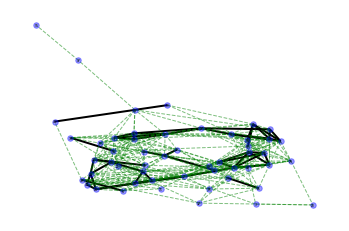

In [13]:

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
# set threshold
# matrix save the similarity of the nodes 
data = dist_matrix_after
mat=np.array(data)
mat[mat<0.5]=0 # remove low similarity pair
mat[mat==1]=0  # remove edge point to node itself

#add edge 
g = nx.Graph()
for i in range(len(mat)):
    for j in range(len(mat)):
        if(mat[i,j]>0):  # don't add edge for too 
          g.add_edge(i, j,weight=mat[i,j])


# according weight divide edges to light edges or heavy edges
elarge = [(u, v) for (u, v, d) in g.edges(data=True) if d['weight'] > 0.8]
esmall = [(u, v) for (u, v, d) in g.edges(data=True) if d['weight'] <= 0.8]
# posistion
pos = nx.spring_layout(g)  # positions for all nodes
# Firstly draw all nodes
# nodes
nx.draw_networkx_nodes(g, pos, node_color='b',node_size=30,alpha=0.4)
# heavey line: solid line; light edges: dashed line
# edges
nx.draw_networkx_edges(g, pos, edgelist=elarge,
                       width=2)
nx.draw_networkx_edges(g, pos, edgelist=esmall,
                       width=1, alpha=0.5, edge_color='g', style='dashed')

# labels
nx.draw_networkx_labels(g, pos, font_size=3, font_family='sans-serif')

plt.axis('off')
plt.savefig("weighted_graph.png")  # save as png
plt.show()